In [1]:
from pyspark.sql.functions import mean, udf, col, round
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [2]:
%matplotlib inline
now = datetime.datetime.now()
print(now)
df1 = spark.read.csv('../data/pluto.csv', header=True)
df2 = spark.read.csv('../data/pluto_18v2_1.csv', header=True)

2019-09-12 14:13:03.657495


In [3]:
for i in df1.columns:
    if i not in df2.columns:
        df1 = df1.drop(i)
        
for i in df2.columns:
    if i not in df1.columns:
        df2 = df2.drop(i)

In [4]:
len(df1.columns) == len(df2.columns)

True

In [5]:
df1 = df1.select([col(A).alias(A.lower()) for A in df1.schema.names])
df2 = df2.select([col(A).alias(A.lower()) for A in df2.schema.names])

double_columns = ['bldgarea', 'facilfar','residfar', 'commfar', 
                  'numbldgs', 'numfloors', 'bldgdepth','bldgfront', 
                  'lotdepth', 'lotfront', 'exempttot', 
                  'assessland', 'assesstot','builtfar']
cols = df2.columns
df1 = df1.select(cols)
df2 = df2.select(cols)

for A in double_columns: 
    df1 = df1.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df2 = df2.withColumn(A, round(col(A).cast(DoubleType()), 2))
    
df1 = df1.select([col(A).alias(A+'_1') for A in df1.schema.names])

colnames = zip(df1.columns, df2.columns)

df = df2.join(df1, df2['bbl'] == df1['bbl_1'])
condo = df.filter(df['lot'].rlike(r'^75'))

In [6]:
@udf
def compare(col1,col2):
    if col1!=col2:
        return 1
    else:
        return 0
    
access_cols = ['exemptland', 'exempttot', 'assessland', 'assesstot']

@udf #special access column comparison
def compare_a(col1,col2):
    try: 
        if abs(col1 - col2) > 10: 
            return 1
        else: 
            return 0
    except: 
        return 0

In [7]:
spark.sql('set spark.sql.caseSensitive=true')
for A,B in colnames:
    if B in access_cols:
        df = df.withColumn(B+'%', compare_a(col(A),col(B)))\
               .drop(A,B)
        condo = condo.withColumn(B+'%', compare_a(col(A),col(B)))\
               .drop(A,B)
    else:
        df = df.withColumn(B+'%', compare(col(A),col(B)))\
                   .drop(A,B)
        condo = condo.withColumn(B+'%', compare(col(A),col(B)))\
                   .drop(A,B)
        
results = df.select(*[mean(col(A)).alias(A) for A in df.columns])
condo_results = condo.select(*[mean(col(A)).alias(A) for A in condo.columns])

In [8]:
start_time = time.time()
results_df = results.toPandas()
condo_results_df = condo_results.toPandas()
elapsed_time = time.time() - start_time

In [9]:
results_df.iloc[0,:].sort_values(ascending=False)[0:30]

edesigdate%       1.000000
basempdate%       1.000000
landmkdate%       1.000000
zoningdate%       1.000000
dcasdate%         1.000000
rpaddate%         1.000000
version%          1.000000
assesstot%        0.991344
condono%          0.989774
landuse%          0.953917
appbbl%           0.893554
tract2010%        0.887774
assessland%       0.852098
sanitdistrict%    0.565950
ext%              0.526605
exempttot%        0.452948
residfar%         0.438458
ownername%        0.319214
schooldist%       0.087596
appdate%          0.080479
address%          0.027350
builtfar%         0.011667
yearalter1%       0.008155
ownertype%        0.006438
unitstotal%       0.006103
numbldgs%         0.005917
numfloors%        0.005258
unitsres%         0.004912
facilfar%         0.004763
bldgarea%         0.004464
Name: 0, dtype: float64

In [10]:
condo_results_df.iloc[0,:].sort_values(ascending=False)[0:30]

edesigdate%       1.000000
zoningdate%       1.000000
rpaddate%         1.000000
dcasdate%         1.000000
version%          1.000000
landmkdate%       1.000000
basempdate%       1.000000
assesstot%        0.991494
landuse%          0.979423
tract2010%        0.956659
ownername%        0.729423
sanitdistrict%    0.680574
exempttot%        0.649060
assessland%       0.644524
appdate%          0.549498
builtfar%         0.529488
condono%          0.325988
appbbl%           0.297634
schooldist%       0.251944
residfar%         0.211601
irrlotcode%       0.179601
ext%              0.176685
yearalter1%       0.155460
yearalter2%       0.097537
lotdepth%         0.092353
address%          0.086601
numfloors%        0.081416
numbldgs%         0.073882
yearbuilt%        0.072019
lotarea%          0.063918
Name: 0, dtype: float64

In [11]:
results0 = pd.read_csv('results_18v1_18v2_1.csv', index_col = False)

In [12]:
results0['mappluto_f%'] = 1
results0['rpaddate%'] = 1
results0['dcasdate%'] = 1
results0['zoningdate%'] = 1
results0['basempdate%'] = 1
results0['masdate%'] = 1
results0['polidate%'] = 1
results0['edesigdate%'] = 1
results0['landmkdate%'] = 1

In [13]:
set(results0.columns) == set(results_df.columns)

False

In [14]:
cols = results_df.columns

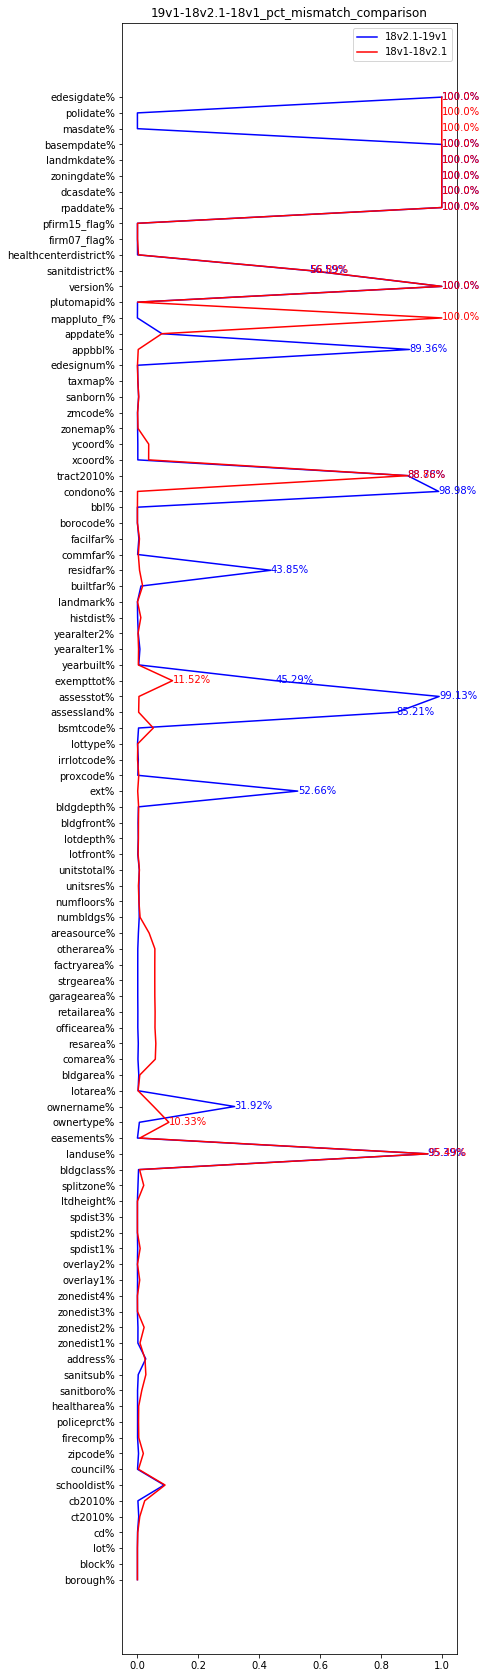

In [15]:
plt.figure(figsize=(6, 30))

plt.plot(results_df.loc[0, cols], range(len(cols)), label = '18v2.1-19v1', color = 'blue')
plt.plot(results0.loc[0, cols], range(len(cols)), label = '18v1-18v2.1', color = 'red')

label = list(results_df.loc[0, cols])
label0 = list(results0.loc[0, cols])

for i in range(len(label)):
    if label[i] >= 0.1:
        plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(np.round(label[i]*100, 2)), size = 10, color = 'blue')
    else: 
        pass
    
for i in range(len(label0)):
    if label0[i] >= 0.1:
        plt.text(x = label0[i] , y = i-0.15, s = '{}%'.format(np.round(label0[i]*100, 2)), size = 10, color = 'red')
    else: 
        pass
    
plt.yticks(range(len(cols)), cols, rotation='horizontal')
plt.legend()
plt.title('19v1-18v2.1-18v1_pct_mismatch_comparison')
plt.savefig('19v1-18v2.1-18v1_pct_mismatch_comparison.png', bbox_inches='tight')
plt.show()

# Checks for condos

In [16]:
condo_results0 = pd.read_csv('condo_results_18v1_18v2_1.csv', index_col = False)
condo_results0['mappluto_f%'] = 1
condo_results0['rpaddate%'] = 1
condo_results0['dcasdate%'] = 1
condo_results0['zoningdate%'] = 1
condo_results0['basempdate%'] = 1
condo_results0['masdate%'] = 1
condo_results0['polidate%'] = 1
condo_results0['edesigdate%'] = 1
condo_results0['landmkdate%'] = 1

In [17]:
set(condo_results0.columns) == set(condo_results_df.columns)

False

In [18]:
condo_cols = condo_results_df.columns

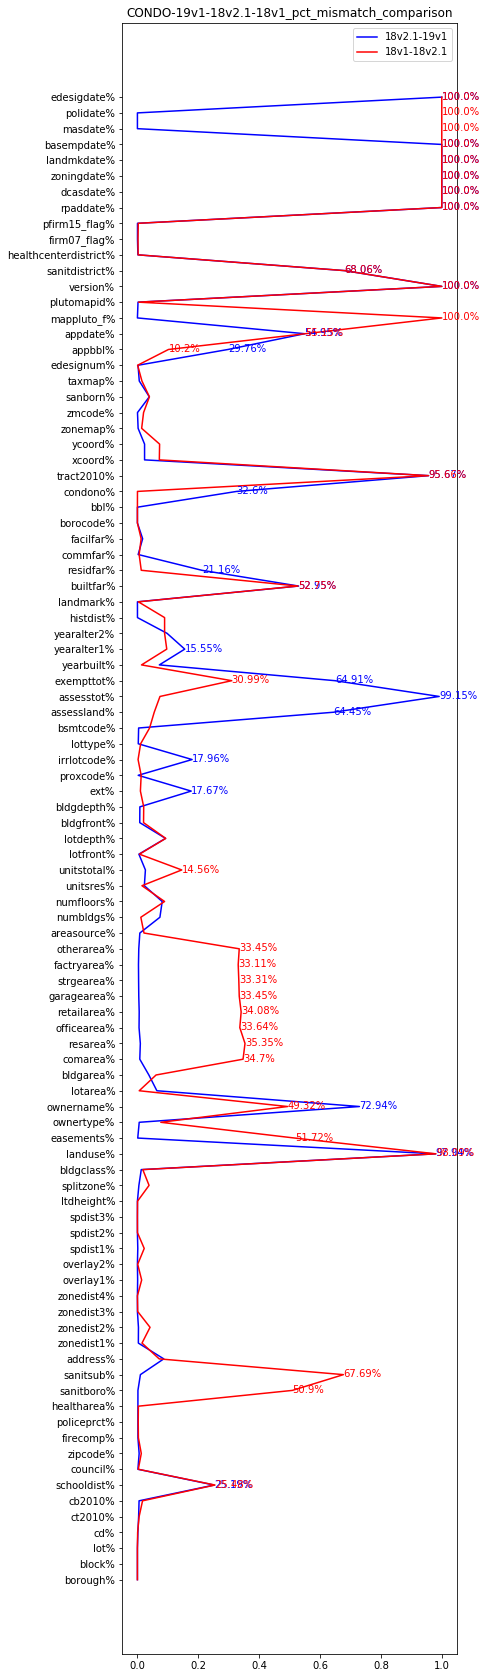

In [19]:
plt.figure(figsize=(6, 30))

plt.plot(condo_results_df.loc[0, condo_cols], range(len(condo_cols)), label = '18v2.1-19v1', color = 'blue')
plt.plot(condo_results0.loc[0, condo_cols], range(len(condo_cols)), label = '18v1-18v2.1', color = 'red')

label = list(condo_results_df.loc[0, condo_cols])
label0 = list(condo_results0.loc[0, condo_cols])

for i in range(len(label)):
    if label[i] >= 0.1:
        plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(np.round(label[i]*100, 2)), size = 10, color = 'blue')
    else: 
        pass
    
for i in range(len(label0)):
    if label0[i] >= 0.1:
        plt.text(x = label0[i] , y = i-0.15, s = '{}%'.format(np.round(label0[i]*100, 2)), size = 10, color = 'red')
    else: 
        pass
    
plt.yticks(range(len(condo_cols)), condo_cols, rotation='horizontal')
plt.legend()
plt.title('CONDO-19v1-18v2.1-18v1_pct_mismatch_comparison')
plt.savefig('CONDO-19v1-18v2.1-18v1_pct_mismatch_comparison.png', bbox_inches='tight')
plt.show()